## Setup and models

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Function to prepare data into tensors suitable for the model
def prepare_data(data_series, seq_len, pred_len, enc_in):
    # Convert pd.Series to numpy array
    data_array = data_series.values.astype(np.float32)

    # Determine number of samples (Batch size)
    num_samples = len(data_array) - seq_len - pred_len + 1

    # Initialize x_train_tensor and y_train_tensor
    x_train_tensor = torch.zeros(num_samples, seq_len, enc_in, dtype=torch.float32)
    y_train_tensor = torch.zeros(num_samples, pred_len, enc_in, dtype=torch.float32)

    # Prepare input sequences (x_train_tensor)
    for i in range(num_samples):
        x_train_tensor[i, :, 0] = torch.tensor(data_array[i:i+seq_len])

    # Prepare target sequences (y_train_tensor)
    for i in range(num_samples):
        y_train_tensor[i, :, 0] = torch.tensor(data_array[i+seq_len:i+seq_len+pred_len])

    return x_train_tensor, y_train_tensor


def prepare_data_L(data_series, seq_len, pred_len, enc_in):
    # Convert pd.Series to numpy array
    data_array = data_series.values.astype(np.float32)

    # Determine number of samples (Batch size)
    num_samples = len(data_array) - seq_len - pred_len + 1

    # Initialize x_train_tensor and y_train_tensor
    x_train_tensor = torch.zeros(num_samples, seq_len, enc_in, dtype=torch.float32)
    y_train_tensor = torch.zeros(num_samples, pred_len, enc_in, dtype=torch.float32)

    # Prepare input sequences (x_train_tensor)
    for i in range(num_samples):
        x_train_tensor[i, :, 0] = torch.tensor(data_array[i:i+seq_len])

    # Prepare target sequences (y_train_tensor)
    for i in range(num_samples):
        y_train_tensor[i, :, 0] = torch.tensor(data_array[i+seq_len:i+seq_len+pred_len])

    return x_train_tensor, y_train_tensor



def prepare_data_df(data_df, seq_len, pred_len):
    # Convert DataFrame to numpy array
    data_array = data_df.values.astype(np.float32)

    # Scale the variables
    scaler = StandardScaler()
    data_array = scaler.fit_transform(data_array)

    # Determine number of samples (Batch size)
    num_samples = len(data_array) - seq_len - pred_len + 1
    enc_in = data_array.shape[1]

    # Initialize x_train_tensor and y_train_tensor
    x_train_tensor = torch.zeros(num_samples, seq_len, enc_in, dtype=torch.float32)
    y_train_tensor = torch.zeros(num_samples, pred_len, enc_in, dtype=torch.float32)

    # Prepare input sequences (x_train_tensor)
    for i in range(num_samples):
        x_train_tensor[i] = torch.tensor(data_array[i:i+seq_len])

    # Prepare target sequences (y_train_tensor)
    for i in range(num_samples):
        y_train_tensor[i] = torch.tensor(data_array[i+seq_len:i+seq_len+pred_len])

    return x_train_tensor, y_train_tensor, scaler


from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

#### MLP Time

In [ ]:
class Model_MLP_T(nn.Module):
    def __init__(self, configs):
        super(Model_MLP_T, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        self.channels = configs.enc_in
        self.individual = configs.individual
        self.scale = 0.02
        self.sparsity_threshold = 0.01
        self.w = nn.Parameter((1 / self.seq_len) * torch.ones([self.seq_len, self.seq_len]))


    def MLP_time(self, x):
        x = x.permute(0, 2, 1)  # B C L
        x = torch.einsum('bij,jk->bik', x, self.w)
        x = x.permute(0, 2, 1)
        return x

    def MLP_frequency_input(self, x):
        x = x.permute(0, 2, 1)  # B C L
        # FFT
        x = torch.fft.fft(x, dim=2, norm='ortho')
        # only real part
        real = x.real
        x = torch.einsum('bij,jk->bik', real, self.w)
        x = x.permute(0, 2, 1)
        return x

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        x = self.MLP_time(x)
        #x = self.MLP_frequency_input(x)
        return x  # [Batch, Output length, Channel]

#### MLP Frequency

In [ ]:
class Model_MLP_F(nn.Module):
    def __init__(self, configs):
        super(Model_MLP_F, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        self.channels = configs.enc_in
        self.individual = configs.individual
        self.scale = 0.02
        self.sparsity_threshold = 0.01
        self.w = nn.Parameter((1 / self.seq_len) * torch.ones([self.seq_len, self.seq_len]))


    def MLP_time(self, x):
        x = x.permute(0, 2, 1)  # B C L
        x = torch.einsum('bij,jk->bik', x, self.w)
        x = x.permute(0, 2, 1)
        return x

    def MLP_frequency_input(self, x):
        x = x.permute(0, 2, 1)  # B C L
        # FFT
        x = torch.fft.fft(x, dim=2, norm='ortho')
        # only real part
        real = x.real
        x = torch.einsum('bij,jk->bik', real, self.w)
        x = x.permute(0, 2, 1)
        return x

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        #x = self.MLP_time(x)
        x = self.MLP_frequency_input(x)
        return x  # [Batch, Output length, Channel]

#### NLinear

In [ ]:
class Model_NLinear(nn.Module):
    """
    Normalization-Linear
    """
    def __init__(self, configs):
        super(Model_NLinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        self.channels = configs.enc_in
        self.individual = configs.individual
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

        self.embed_size = 512
        self.embeddings = nn.Parameter(torch.randn(1, self.embed_size))
        self.embed_linear = nn.Linear(self.seq_len * self.embed_size, self.pred_len)

        # Use this line if you want to visualize the weights
        self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]

        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.pred_len, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x


#### DLinear

In [ ]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model_DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(Model_DLinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            #seasonal_output = seasonal_init
            trend_output = self.Linear_Trend(trend_init)
            #trend_output = trend_init

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


#### Energy - Time

In [ ]:
class Model_Energy_T(nn.Module):
    def __init__(self, configs):
        super(Model_Energy_T, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.channels = configs.enc_in
        self.individual = configs.individual
        self.embed_size = 128
        self.scale = 0.02
        self.sparsity_threshold = 0.01
        self.embeddings = nn.Parameter(torch.randn(1, self.embed_size))
        self.w = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.embed_linear = nn.Linear(self.seq_len * self.embed_size, self.pred_len)

        self.f_r = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.f_i = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.rb2 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.ib2 = nn.Parameter(self.scale * torch.randn(self.embed_size))

    def MLP_time(self, x):
        B, T, N = x.shape
        x = x.permute(0, 2, 1)  # B, N, T
        x = x.unsqueeze(3)
        y = self.embeddings
        x = x * y
        x = torch.einsum('bijd,dd->bijd', x, self.w)
        #tmp = x
        x = self.embed_linear(x.reshape(B, N, -1)).permute(0, 2, 1)
        return x #,tmp

    def MLP_frequency(self, x):
        B, L, N = x.shape
        x = x.permute(0, 2, 1)  # B, N, T
        x = x.unsqueeze(3)
        y = self.embeddings
        x = x * y
        x = torch.fft.rfft(x, dim=2, norm='ortho')
        o1_real = torch.zeros([B, N, L // 2 + 1, self.embed_size],
                              device=x.device)
        o1_imag = torch.zeros([B, N, L // 2 + 1, self.embed_size],
                              device=x.device)

        # set the real part of input to 0
        # x.real = torch.zeros(x.real.shape, device=x.device)
        # set the imaginary part of input to 0
        # x.imag = torch.zeros(x.imag.shape, device=x.device)
        # set the imaginary part of weights to 0
        # f_i = torch.zeros([self.embed_size, self.embed_size], device=x.device)
        # set the real part of weights to 0
        # f_r = torch.zeros([self.embed_size, self.embed_size], device=x.device)

        o1_real = F.relu(
            torch.einsum('bijd,dd->bijd', x.real, self.f_r) - \
            torch.einsum('bijd,dd->bijd', x.imag, self.f_i) + \
            self.rb2
        )

        o1_imag = F.relu(
            torch.einsum('bijd,dd->bijd', x.imag, self.f_r) + \
            torch.einsum('bijd,dd->bijd', x.real, self.f_i) + \
            self.ib2
        )

        y = torch.stack([o1_real, o1_imag], dim=-1)
        y = F.softshrink(y, lambd=self.sparsity_threshold)
        y = torch.view_as_complex(y)
        x = torch.fft.irfft(y, n=self.seq_len, dim=2, norm="ortho")
        x = self.embed_linear(x.reshape(B, N, -1)).permute(0, 2, 1)
        return x

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        x = self.MLP_time(x)
        #x = self.MLP_frequency(x)
        return x  # [Batch, Output length, Channel]

#### Energy - Frequency

In [ ]:
class Model_Energy_F(nn.Module):
    def __init__(self, configs):
        super(Model_Energy_F, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.channels = configs.enc_in
        self.individual = configs.individual
        self.embed_size = 128
        self.scale = 0.02
        self.sparsity_threshold = 0.01
        self.embeddings = nn.Parameter(torch.randn(1, self.embed_size))
        self.w = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.embed_linear = nn.Linear(self.seq_len * self.embed_size, self.pred_len)

        self.f_r = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.f_i = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.rb2 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.ib2 = nn.Parameter(self.scale * torch.randn(self.embed_size))

    def MLP_time(self, x):
        B, T, N = x.shape
        x = x.permute(0, 2, 1)  # B, N, T
        x = x.unsqueeze(3)
        y = self.embeddings
        x = x * y
        x = torch.einsum('bijd,dd->bijd', x, self.w)
        #tmp = x
        x = self.embed_linear(x.reshape(B, N, -1)).permute(0, 2, 1)
        return x #,tmp

    def MLP_frequency(self, x):
        B, L, N = x.shape
        x = x.permute(0, 2, 1)  # B, N, T
        x = x.unsqueeze(3)
        y = self.embeddings
        x = x * y
        x = torch.fft.rfft(x, dim=2, norm='ortho')
        o1_real = torch.zeros([B, N, L // 2 + 1, self.embed_size],
                              device=x.device)
        o1_imag = torch.zeros([B, N, L // 2 + 1, self.embed_size],
                              device=x.device)

        # set the real part of input to 0
        # x.real = torch.zeros(x.real.shape, device=x.device)
        # set the imaginary part of input to 0
        # x.imag = torch.zeros(x.imag.shape, device=x.device)
        # set the imaginary part of weights to 0
        # f_i = torch.zeros([self.embed_size, self.embed_size], device=x.device)
        # set the real part of weights to 0
        # f_r = torch.zeros([self.embed_size, self.embed_size], device=x.device)

        o1_real = F.relu(
            torch.einsum('bijd,dd->bijd', x.real, self.f_r) - \
            torch.einsum('bijd,dd->bijd', x.imag, self.f_i) + \
            self.rb2
        )

        o1_imag = F.relu(
            torch.einsum('bijd,dd->bijd', x.imag, self.f_r) + \
            torch.einsum('bijd,dd->bijd', x.real, self.f_i) + \
            self.ib2
        )

        y = torch.stack([o1_real, o1_imag], dim=-1)
        y = F.softshrink(y, lambd=self.sparsity_threshold)
        y = torch.view_as_complex(y)
        x = torch.fft.irfft(y, n=self.seq_len, dim=2, norm="ortho")
        x = self.embed_linear(x.reshape(B, N, -1)).permute(0, 2, 1)
        return x

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        #x = self.MLP_time(x)
        x = self.MLP_frequency(x)
        return x  # [Batch, Output length, Channel]

### FreTS

In [22]:
class ModelFreTS(nn.Module):
    def __init__(self, configs):
        super(ModelFreTS, self).__init__()
        self.embed_size = 128 #embed_size
        self.hidden_size = 256 #hidden_size
        self.pre_length = configs.pred_len
        self.feature_size = configs.enc_in #channels
        self.seq_length = configs.seq_len
        self.channel_independence = configs.channel_independence
        self.sparsity_threshold = 0.01
        self.scale = 0.02
        self.embeddings = nn.Parameter(torch.randn(1, self.embed_size))
        self.r1 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.i1 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.rb1 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.ib1 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.r2 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.i2 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.rb2 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.ib2 = nn.Parameter(self.scale * torch.randn(self.embed_size))

        self.fc = nn.Sequential(
            nn.Linear(self.seq_length * self.embed_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.pre_length)
        )

    # dimension extension
    def tokenEmb(self, x):
        # x: [Batch, Input length, Channel]
        x = x.permute(0, 2, 1)
        x = x.unsqueeze(3)
        # N*T*1 x 1*D = N*T*D
        y = self.embeddings
        return x * y

    # frequency temporal learner
    def MLP_temporal(self, x, B, N, L):
        # [B, N, T, D]
        x = torch.fft.rfft(x, dim=2, norm='ortho') # FFT on L dimension
        y = self.FreMLP(B, N, L, x, self.r2, self.i2, self.rb2, self.ib2)
        x = torch.fft.irfft(y, n=self.seq_length, dim=2, norm="ortho")
        return x

    # frequency channel learner
    def MLP_channel(self, x, B, N, L):
        # [B, N, T, D]
        x = x.permute(0, 2, 1, 3)
        # [B, T, N, D]
        x = torch.fft.rfft(x, dim=2, norm='ortho') # FFT on N dimension
        y = self.FreMLP(B, L, N, x, self.r1, self.i1, self.rb1, self.ib1)
        x = torch.fft.irfft(y, n=self.feature_size, dim=2, norm="ortho")
        x = x.permute(0, 2, 1, 3)
        # [B, N, T, D]
        return x

    # frequency-domain MLPs
    # dimension: FFT along the dimension, r: the real part of weights, i: the imaginary part of weights
    # rb: the real part of bias, ib: the imaginary part of bias
    def FreMLP(self, B, nd, dimension, x, r, i, rb, ib):
        o1_real = torch.zeros([B, nd, dimension // 2 + 1, self.embed_size],
                              device=x.device)
        o1_imag = torch.zeros([B, nd, dimension // 2 + 1, self.embed_size],
                              device=x.device)

        o1_real = F.relu(
            torch.einsum('bijd,dd->bijd', x.real, r) - \
            torch.einsum('bijd,dd->bijd', x.imag, i) + \
            rb
        )

        o1_imag = F.relu(
            torch.einsum('bijd,dd->bijd', x.imag, r) + \
            torch.einsum('bijd,dd->bijd', x.real, i) + \
            ib
        )

        y = torch.stack([o1_real, o1_imag], dim=-1)
        y = F.softshrink(y, lambd=self.sparsity_threshold)
        y = torch.view_as_complex(y)
        return y

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        B, T, N = x.shape
        # embedding x: [B, N, T, D]
        x = self.tokenEmb(x)
        bias = x
        # [B, N, T, D]
        if self.channel_independence == '1':
            x = self.MLP_channel(x, B, N, T)
        # [B, N, T, D]
        x = self.MLP_temporal(x, B, N, T)
        x = x + bias
        x = self.fc(x.reshape(B, N, -1)).permute(0, 2, 1)
        return x


# Update the Configs class
class Configs:
    def __init__(self, seq_len, pred_len, enc_in, channel_independence):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.enc_in = enc_in
        self.channel_independence = channel_independence

#### Configs

In [ ]:
class Configs_1:
    def __init__(self, seq_len, pred_len, enc_in, individual):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.enc_in = enc_in
        self.individual = individual

## Artificial data

In [ ]:
n = 596  # Number of data points
p = 1    # Order of the AR process
period = 12  # Period of the periodic component

pred_len = 96

################### Generate AR series ###################
time_indices = np.arange(n)
periodic_component = np.sin(2 * np.pi * time_indices / period)
#periodic_component_2 = np.sin(3 * np.pi * time_indices / period)
#periodic_component_3 = np.sin(4 * np.pi * time_indices / period)
#periodic_component = periodic_component + periodic_component_2 + periodic_component_3

ar_series = np.zeros(n)
for i in range(p, n):
    ar_series[i] = 0.8 * ar_series[i-1] + 0.1 * periodic_component[i] + np.random.normal(0, 0.01)


series = pd.Series(ar_series)

n = len(series) - pred_len
te = series[n:]
series = series[:n]
#################### Frequency Domain ####################
frequency_sequence = np.fft.fft(series)

# Frequency bins
freq_bins = np.fft.fftfreq(len(series))

# Plot the time domain sequence
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.stem(series, use_line_collection=True)
plt.title('Time Domain Sequence')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Plot the frequency domain sequence (magnitude)
plt.subplot(1, 2, 2)
plt.stem(freq_bins, np.abs(frequency_sequence), use_line_collection=True)
plt.title('Frequency Domain Sequence')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()

plt.figure(figsize=(10, 6))
plt.plot(series, label='AR Series')
plt.plot(periodic_component, label='Periodic Component')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Periodic AR Process')
plt.grid(True)
plt.show()

## Real data

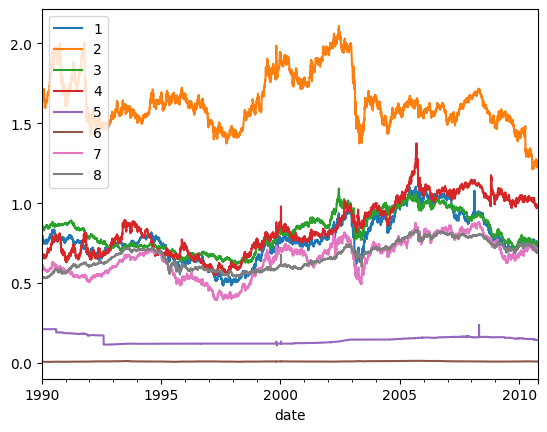

In [27]:
from sklearn.preprocessing import MinMaxScaler
#df = pd.read_csv('traffic.csv')
df = pd.read_csv('exchange_rate.csv')
#df = pd.read_csv('data/ETTh1.csv')

df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)
df.plot()

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
pred_len = 96

<Axes: >

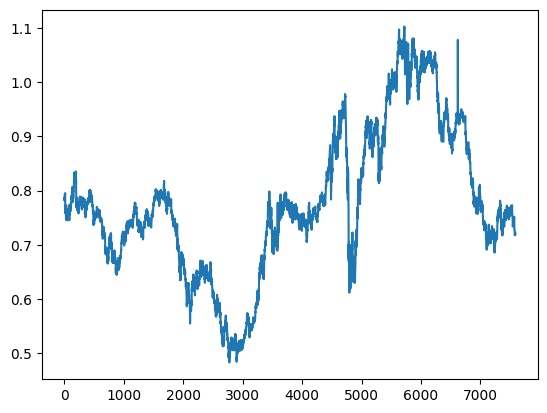

In [4]:
series = pd.Series(exchange_rate['1'])
series.plot()

In [5]:
n = len(df) - 720
df_te = df[n:]
df = df[:n]

In [5]:
n = len(series) - 720
series_te = series[n:]
series = series[:n]

## MLP in time domain

In [ ]:
############### Create a model and train it ###############
seq_len = 96
pred_len = 96
enc_in = 1
individual = False
configs = Configs_1(seq_len, pred_len, enc_in, individual)

# Initialize model
model = Model_MLP_T(configs)

# Prepare data
x_train, y_train = prepare_data(series, seq_len, pred_len, enc_in)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


weights = model.w.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = series.values[-seq_len:].reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array for plotting
y_pred = y_pred.detach().numpy().flatten()

# Plot the original series and the predictions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n, n + pred_len), y_pred, label='Predicted', color='red')
plt.plot(np.arange(n, n + pred_len), series_te, label='True', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('AR Series and Predictions')
plt.grid(True)
plt.show()

error = np.mean(np.abs(series_te - y_pred))
print('MAE:', error)

In [ ]:
# Assuming data_df is your DataFrame with 10 columns and 10,000 rows
seq_len = 96
pred_len = 96
enc_in = df.shape[1]

# Prepare data
x_train, y_train, scaler = prepare_data_df(df, seq_len, pred_len)

# Create Dataset and DataLoader
train_dataset = TimeSeriesDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Example batch size

# Model instantiation
configs = Configs_1(seq_len, pred_len, enc_in, individual=False)
model = Model_MLP_T(configs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Step 3: Make predictions
model.eval()

weights = model.w.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = df.values[-seq_len:].reshape(seq_len, enc_in)
x_input = scaler.transform(x_input)
x_input = x_input.reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array and inverse scale for plotting
y_pred = y_pred.detach().numpy().flatten()
y_pred = scaler.inverse_transform(y_pred.reshape(-1, enc_in))

# Plot the original series and the predictions
n = len(df)
for i in range(enc_in):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(n, n + pred_len), y_pred[:, i], label='Predicted', color='red')
    plt.plot(np.arange(n, n + pred_len), df_te[str(i)], label='True', color='green')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f'Time Series and Predictions for Column {i}')
    plt.grid(True)
    plt.show()


error = np.mean(np.abs(df_te - y_pred))
print('MAE:', error)

## MLP in frequency domain

In [ ]:
############### Create a model and train it ###############
seq_len = 96
pred_len = pred_len
enc_in = 1
individual = False
configs = Configs_1(seq_len, pred_len, enc_in, individual)

# Initialize model
model = Model_MLP_F(configs)

# Prepare data
x_train, y_train = prepare_data(series, seq_len, pred_len, enc_in)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


weights = model.w.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = series.values[-seq_len:].reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array for plotting
y_pred = y_pred.detach().numpy().flatten()

# Plot the original series and the predictions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n, n + pred_len), y_pred, label='Predicted', color='red')
plt.plot(np.arange(n, n + pred_len), series_te, label='True', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('AR Series and Predictions')
plt.grid(True)
plt.show()

error = np.mean(np.abs(series_te - y_pred))
print('MAE:', error)

In [ ]:
# Assuming data_df is your DataFrame with 10 columns and 10,000 rows
seq_len = 96
pred_len = 96
enc_in = df.shape[1]

# Prepare data
x_train, y_train, scaler = prepare_data_df(df, seq_len, pred_len)

# Create Dataset and DataLoader
train_dataset = TimeSeriesDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Example batch size

# Model instantiation
configs = Configs_1(seq_len, pred_len, enc_in, individual=False)
model = Model_MLP_F(configs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Step 3: Make predictions
model.eval()

weights = model.w.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = df.values[-seq_len:].reshape(seq_len, enc_in)
x_input = scaler.transform(x_input)
x_input = x_input.reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array and inverse scale for plotting
y_pred = y_pred.detach().numpy().flatten()
y_pred = scaler.inverse_transform(y_pred.reshape(-1, enc_in))

# Plot the original series and the predictions
# Create separate plots for each column
for i in range(enc_in):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(n, n + pred_len), y_pred[:, i], label='Predicted', color='red')
    plt.plot(np.arange(n, n + pred_len), df_te[str(i)], label='True', color='green')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f'Time Series and Predictions for Column {i}')
    plt.grid(True)
    plt.show()


error = np.mean(np.abs(df_te - y_pred))
print('MAE:', error)

## NLinear

### Univariate

In [ ]:
############### Create a model and train it ###############
seq_len = 96
pred_len = 96
enc_in = 1
individual = False
configs = Configs_1(seq_len, pred_len, enc_in, individual)

# Initialize model
model = Model_NLinear(configs)

# Prepare data
x_train, y_train = prepare_data(series, seq_len, pred_len, enc_in)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


weights = model.Linear.weight.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = series.values[-seq_len:].reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array for plotting
y_pred = y_pred.detach().numpy().flatten()

# Plot the original series and the predictions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n, n + pred_len), y_pred, label='Predicted', color='red')
plt.plot(np.arange(n, n + pred_len), series_te, label='True', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Series and Predictions')
plt.grid(True)
plt.show()

error = np.mean(np.abs(series_te - y_pred))
print('MAE:', error)

### Multivariate

In [ ]:
# Assuming data_df is your DataFrame with 10 columns and 10,000 rows
seq_len = 96
pred_len = 96
enc_in = df.shape[1]

# Prepare data
x_train, y_train, scaler = prepare_data_df(df, seq_len, pred_len)

# Create Dataset and DataLoader
train_dataset = TimeSeriesDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Example batch size

# Model instantiation
configs = Configs_1(seq_len, pred_len, enc_in, individual=False)
model = Model_NLinear(configs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Step 3: Make predictions
model.eval()

weights = model.Linear.weight.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = df.values[-seq_len:].reshape(seq_len, enc_in)
x_input = scaler.transform(x_input)
x_input = x_input.reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array and inverse scale for plotting
y_pred = y_pred.detach().numpy().flatten()
y_pred = scaler.inverse_transform(y_pred.reshape(-1, enc_in))

# Plot the original series and the predictions
#n = len(df)
#for i in range(enc_in):
#    plt.figure(figsize=(10, 6))
#    plt.plot(np.arange(n, n + pred_len), y_pred[:, i], label='Predicted', color='red')
#    plt.plot(np.arange(n, n + pred_len), df_te[str(i)], label='True', color='green')
#    plt.xlabel('Time')
#    plt.ylabel('Value')
#    plt.legend()
#    plt.title(f'Time Series and Predictions for Column {i}')
#    plt.grid(True)
#    plt.show()

n = len(df)
clnames = df.columns
for i in range(enc_in):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index[int(len(df)*0.95):len(df)], df[clnames[i]][int(len(df)*0.95):len(df)], label='Time Series', color='blue')
    plt.plot(df_te.index[:pred_len], y_pred[:, i], label='Predicted', color='red')
    plt.plot(df_te.index[:pred_len], df_te[clnames[i]][:pred_len], label='True', color='green')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f'Time Series and Predictions for Column {i}')
    plt.grid(True)
    plt.show()


error = np.mean(np.abs(df_te[:pred_len] - y_pred))
print('MAE:', error)

## DLinear

In [ ]:
############### Create a model and train it ###############
seq_len = 96
pred_len = 96
enc_in = 1
individual = False
configs = Configs_1(seq_len, pred_len, enc_in, individual)

# Initialize model
model = Model_DLinear(configs)

# Prepare data
x_train, y_train = prepare_data(series, seq_len, pred_len, enc_in)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


weights = model.Linear_Seasonal.weight.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain - Seasonal')
plt.show()

weights = model.Linear_Trend.weight.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain - Trend')
plt.show()


# Use the last seq_len points from the training data to predict the next pred_len points
x_input = series.values[-seq_len:].reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array for plotting
y_pred = y_pred.detach().numpy().flatten()

# Plot the original series and the predictions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n, n + pred_len), y_pred, label='Predicted', color='red')
plt.plot(np.arange(n, n + pred_len), series_te, label='True', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Series and Predictions')
plt.grid(True)
plt.show()

error = np.mean(np.abs(series_te - y_pred))
print('MAE:', error)

In [ ]:
# Assuming data_df is your DataFrame with 10 columns and 10,000 rows
seq_len = 96
pred_len = 96
enc_in = df.shape[1]

# Prepare data
x_train, y_train, scaler = prepare_data_df(df, seq_len, pred_len)

# Create Dataset and DataLoader
train_dataset = TimeSeriesDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Example batch size

# Model instantiation
configs = Configs_1(seq_len, pred_len, enc_in, individual=False)
model = Model_DLinear(configs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Step 3: Make predictions
model.eval()

weights = model.Linear_Seasonal.weight.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain - Seasonal')
plt.show()

weights = model.Linear_Trend.weight.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Look-back Window (L)')
plt.ylabel('Forecasting Time Steps (T)')
plt.title('Visualization of Weights in Time Domain - Trend')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = df.values[-seq_len:].reshape(seq_len, enc_in)
x_input = scaler.transform(x_input)
x_input = x_input.reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array and inverse scale for plotting
y_pred = y_pred.detach().numpy().flatten()
y_pred = scaler.inverse_transform(y_pred.reshape(-1, enc_in))

# Plot the original series and the predictions
n = len(df)
for i in range(enc_in):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(n, n + pred_len), y_pred[:, i], label='Predicted', color='red')
    plt.plot(np.arange(n, n + pred_len), df_te[str(i)], label='True', color='green')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f'Time Series and Predictions for Column {i}')
    plt.grid(True)
    plt.show()


error = np.mean(np.abs(df_te - y_pred))
print('MAE:', error)

## FreTS

In [33]:
def train_model(model, X_train, y_train, epochs, batch_size):

    # MSE Loss
    mse = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

            outputs = model(batch_X)

            # Evaluate MSE loss and backpropagate
            loss = mse(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Log the loss every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}')

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def test_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    # Reshaping the data to the original shape
    # before evaluating the metrics
    y_test_inv = y_test.reshape(-1, y_test.shape[-1])
    y_pred_inv = y_pred.reshape(-1, y_pred.shape[-1])

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    return mae, rmse, y_test_inv, y_pred_inv, y_pred

In [23]:
def build_designMatrixAndPrediction(data, lookback_window, prediction_length):

    # Each row of X contains the sequence of data points of length lookback_window
    # Each row of y contains the sequence of data points of length prediction_length
    X = []
    y = []

    for i in range(len(data) - lookback_window - prediction_length + 1):
        X.append(data[i : i+lookback_window])
        y.append(data[i+lookback_window : i+lookback_window+prediction_length])

    return np.array(X), np.array(y)

In [30]:
seq_len = 96
pred_len = 96
X, y = build_designMatrixAndPrediction(df, seq_len, pred_len)

In [83]:
X.shape

(7397, 96, 8)

In [31]:
train_size = int(len(X) * 0.8)
X_train, X_test = torch.FloatTensor(X[:train_size]), torch.FloatTensor(X[train_size:])
y_train, y_test = torch.FloatTensor(y[:train_size]), torch.FloatTensor(y[train_size:])

In [130]:
enc_in = 1
channel_independence = '1'  # or '0'
configs = Configs(seq_len, pred_len, enc_in, channel_independence)

model_fre = ModelFreTS(configs)

train_model(model_fre, X_train, y_train, epochs = 30, batch_size = 32)

Epoch [10/30] - Loss: 0.0078
Epoch [20/30] - Loss: 0.0089
Epoch [30/30] - Loss: 0.0070


In [131]:
mae, rmse, y_test_inv, y_pred_inv, y_pred = test_model(model_fre, X_test, y_test)

In [132]:
mae

0.046123877

In [73]:
y_pred_inv.shape

torch.Size([142080, 8])

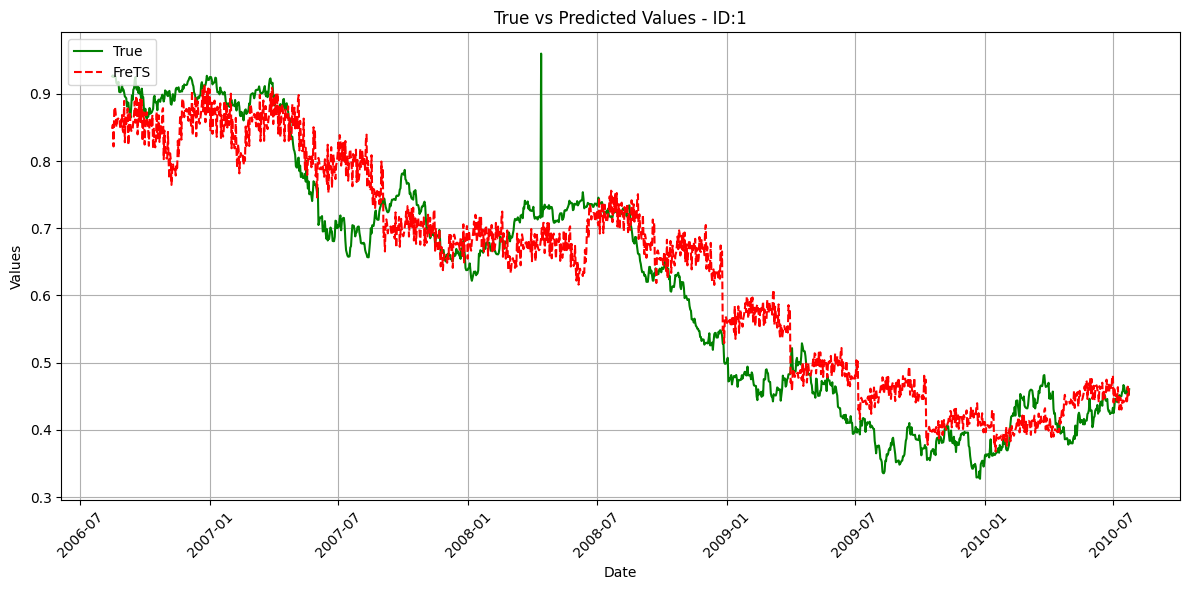

In [268]:
plotdf = []
id = 0
for i in range(0, 1480-96, 96):
    plotdf.append(y_test[i, :, id])
plo = torch.cat(plotdf, dim=0)

plotdf = []
for i in range(0, 1480-96, 96):
    plotdf.append(y_pred[i, :, id])
pl = torch.cat(plotdf, dim=0)

plt.figure(figsize=(12, 6))
plt.plot(df.index[int(len(df)*0.8):-(78)],plo, label='True', linestyle='-', color='green')
plt.plot(df.index[int(len(df)*0.8):-(78)], pl, label='FreTS', linestyle='--', color='red')

plt.title(f'True vs Predicted Values - ID:{id+1}')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels if they are dates

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

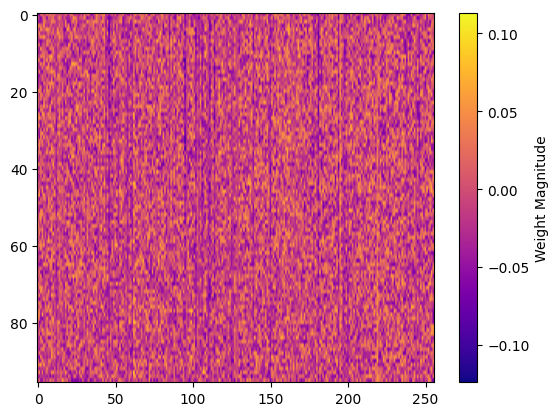

In [278]:
plt.imshow(model_fre.fc[2].weight.detach().numpy(), aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.show()

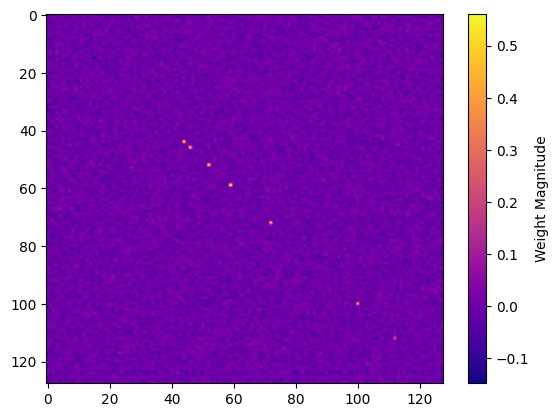

In [279]:
plt.imshow(model_fre.r2.detach().numpy(), aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.show()

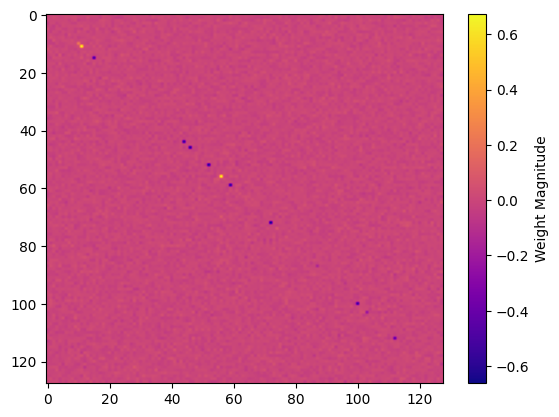

In [280]:
plt.imshow(model_fre.r1.detach().numpy(), aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.show()

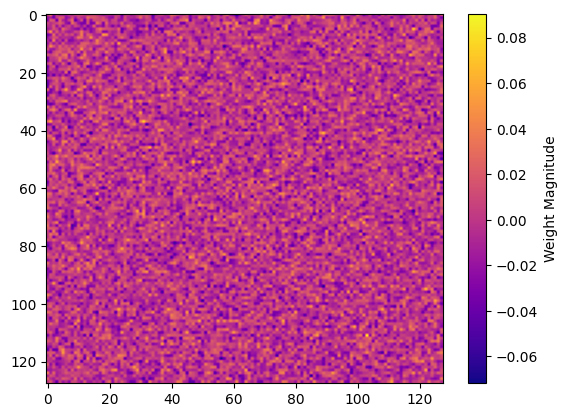

In [281]:
plt.imshow(model_fre.i1.detach().numpy(), aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.show()

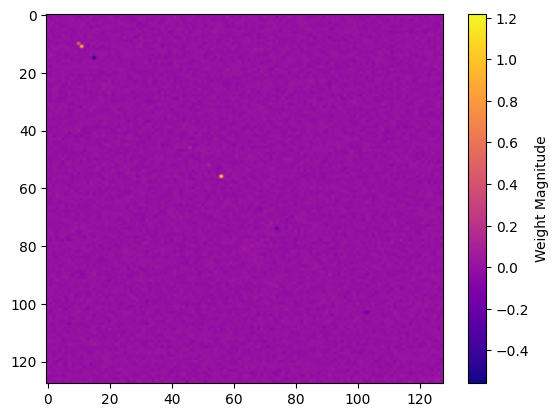

In [282]:
plt.imshow(model_fre.i2.detach().numpy(), aspect='auto', cmap='plasma')
plt.colorbar(label='Weight Magnitude')
plt.show()

## Energy Compaction - Time Domain

In [ ]:
# Assuming data_df is your DataFrame with 10 columns and 10,000 rows
seq_len = 96
pred_len = 96
enc_in = df.shape[1]

# Prepare data
x_train, y_train, scaler = prepare_data_df(df, seq_len, pred_len)

# Create Dataset and DataLoader
train_dataset = TimeSeriesDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Example batch size

# Model instantiation
configs = Configs_1(seq_len, pred_len, enc_in, individual=False)
model = Model_Energy_T(configs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Step 3: Make predictions
model.eval()

weights = model.f_r.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight normalized')
plt.title('Visualization of Weights (Real part) in Time Domain')
plt.show()

weights = model.f_i.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight normalized')
plt.title('Visualization of Weights (Imaginary part) in Time Domain')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = df.values[-seq_len:].reshape(seq_len, enc_in)
x_input = scaler.transform(x_input)
x_input = x_input.reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array and inverse scale for plotting
y_pred = y_pred.detach().numpy().flatten()
y_pred = scaler.inverse_transform(y_pred.reshape(-1, enc_in))

# Plot the original series and the predictions
n = len(df)
for i in range(enc_in):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(n, n + pred_len), y_pred[:, i], label='Predicted', color='red')
    plt.plot(np.arange(n, n + pred_len), df_te[str(i)], label='True', color='green')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f'Time Series and Predictions for Column {i}')
    plt.grid(True)
    plt.show()


error = np.mean(np.abs(df_te - y_pred))
print('MAE:', error)

## Energy Compaction - Frequency Domain

In [ ]:
# Assuming data_df is your DataFrame with 10 columns and 10,000 rows
seq_len = 96
pred_len = 96
enc_in = df.shape[1]

# Prepare data
x_train, y_train, scaler = prepare_data_df(df, seq_len, pred_len)

# Create Dataset and DataLoader
train_dataset = TimeSeriesDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Example batch size

# Model instantiation
configs = Configs_1(seq_len, pred_len, enc_in, individual=False)
model = Model_Energy_F(configs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Step 3: Make predictions
model.eval()

weights = model.f_r.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight normalized')
plt.title('Visualization of Weights (Real part) in Time Domain')
plt.show()

weights = model.f_i.detach().numpy()

# Visualize the weights
plt.figure(figsize=(10, 8))
plt.imshow(weights, aspect='auto', cmap='plasma')
plt.colorbar(label='Weight normalized')
plt.title('Visualization of Weights (Imaginary part) in Time Domain')
plt.show()

# Use the last seq_len points from the training data to predict the next pred_len points
x_input = df.values[-seq_len:].reshape(seq_len, enc_in)
x_input = scaler.transform(x_input)
x_input = x_input.reshape(1, seq_len, enc_in)
x_input = torch.tensor(x_input, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(x_input)

# Convert predictions to numpy array and inverse scale for plotting
y_pred = y_pred.detach().numpy().flatten()
y_pred = scaler.inverse_transform(y_pred.reshape(-1, enc_in))

# Plot the original series and the predictions
n = len(df)
for i in range(enc_in):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(n, n + pred_len), y_pred[:, i], label='Predicted', color='red')
    plt.plot(np.arange(n, n + pred_len), df_te[str(i)], label='True', color='green')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f'Time Series and Predictions for Column {i}')
    plt.grid(True)
    plt.show()


error = np.mean(np.abs(df_te - y_pred))
print('MAE:', error)

# Transformers Plot

In [ ]:
!pip install neuralforecast

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv("/kaggle/input/time-series-forecasts-popular-benchmark-datasets/exchange_rate.csv")
data['ds'] = pd.to_datetime(data['date'])
data.drop(columns=['date'], inplace=True)

numeric_columns = data.columns.difference(['ds'])
data[numeric_columns] = MinMaxScaler().fit_transform(data[numeric_columns])

data.head()

,1,2,3,4,5,6,7,8,ds
0,0.488023,0.445104,0.514050,0.103674,0.792386,0.084053,0.408496,0.005351,1990-01-01
1,0.482048,0.443990,0.512794,0.102847,0.792386,0.087651,0.410540,0.000447,1990-01-02
2,0.489961,0.465495,0.512638,0.121012,0.792386,0.103771,0.417286,0.008040,1990-01-03
3,0.488831,0.474075,0.514835,0.123568,0.792386,0.100604,0.416672,0.000000,1990-01-04
4,0.487054,0.491903,0.514678,0.130396,0.792386,0.098733,0.419739,0.011635,1990-01-05


In [ ]:
df_melted = data.melt(id_vars=['ds'], var_name='unique_id', value_name='y')
df_melted

,ds,unique_id,y
0,1990-01-01,1,0.488023
1,1990-01-02,1,0.482048
2,1990-01-03,1,0.489961
3,1990-01-04,1,0.488831
4,1990-01-05,1,0.487054
...,...,...,...
60699,2010-10-06,8,0.533590
60700,2010-10-07,8,0.539171
60701,2010-10-08,8,0.542835
60702,2010-10-09,8,0.541290


In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import DLinear, NLinear, Informer, Autoformer, PatchTST, FEDformer, VanillaTransformer
from neuralforecast.losses.numpy import mae

horizon = 96
models = [
          DLinear(input_size=96, h=horizon, max_steps = 100, val_check_steps=10, early_stop_patience_steps=3),
          NLinear(input_size=96, h=horizon, max_steps = 100, val_check_steps=10, early_stop_patience_steps=3),
          Informer(h=horizon, input_size=96, max_steps=20, val_check_steps=10, early_stop_patience_steps=3),
          Autoformer(h=horizon, input_size=96, max_steps=20, val_check_steps=10, early_stop_patience_steps=3),
          PatchTST(h=horizon, input_size=96, max_steps=20, val_check_steps=10, early_stop_patience_steps=3),
          VanillaTransformer(h=horizon, input_size=96, max_steps=20, val_check_steps=10, early_stop_patience_steps=3)
          ]
nf = NeuralForecast(models=models, freq='D')

n_time = len(df_melted.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

yhat_df = nf.cross_validation(df=df_melted,
                              val_size=val_size,
                              test_size=test_size,
                               n_windows=None)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
yhat_df

,ds,cutoff,DLinear,NLinear,Informer,Autoformer,PatchTST,VanillaTransformer,y
unique_id,,,,,,,,,
1,2006-08-16,2006-08-15,0.802825,0.949700,0.557187,0.881881,0.875039,0.630726,0.877865
1,2006-08-17,2006-08-15,0.871955,0.876898,0.576757,0.877618,0.871727,0.881517,0.894722
1,2006-08-18,2006-08-15,0.829608,0.970646,0.574329,0.872934,0.875598,0.906013,0.897195
1,2006-08-19,2006-08-15,0.336027,0.903825,0.588239,0.866692,0.872960,0.953991,0.887473
1,2006-08-20,2006-08-15,0.888188,0.924278,0.612790,0.870361,0.879250,1.004513,0.888180
...,...,...,...,...,...,...,...,...,...
8,2010-10-06,2010-07-06,0.635095,0.688752,0.537158,0.674349,0.685988,0.750230,0.533590
8,2010-10-07,2010-07-06,0.019766,0.719728,0.521448,0.579668,0.687636,0.781909,0.539171
8,2010-10-08,2010-07-06,0.484762,0.612375,0.542996,0.613517,0.687603,0.775381,0.542835


In [ ]:
print('DLinear' ,mae(yhat_df['y'].values, yhat_df['DLinear'].values))
print('NLinear', mae(yhat_df['y'].values, yhat_df['NLinear'].values))
print('Informer', mae(yhat_df['y'].values, yhat_df['Informer'].values))
print('Autoformer', mae(yhat_df['y'].values, yhat_df['Autoformer'].values))
print('PAtchTST', mae(yhat_df['y'].values, yhat_df['PatchTST'].values))
print('Vanilla Trans', mae(yhat_df['y'].values, yhat_df['VanillaTransformer'].values))

DLinear 0.17395466615534125
NLinear 0.05990319593893343
Informer 0.15511928410328707
Autoformer 0.06530628476301335
PAtchTST 0.034788284864681926
Vanilla Trans 0.15011628900853946


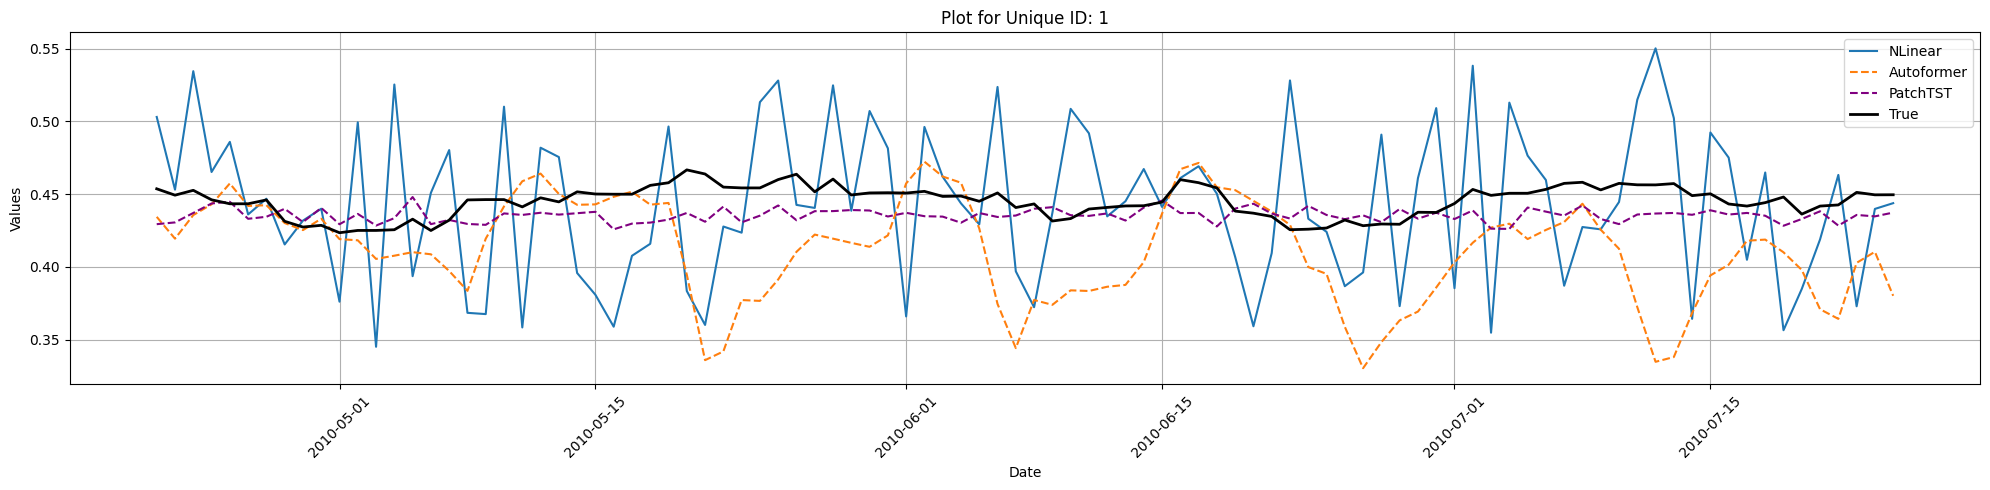

In [ ]:
import matplotlib.pyplot as plt
# Specify the unique_id to plot
unique_id_to_plot = '1' 

# Filter the DataFrame for the specific unique_id
Y_plot = yhat_df.loc[unique_id_to_plot]


cutoffs = yhat_df['cutoff'].unique()[::horizon]  
Y_plot = Y_plot[Y_plot['cutoff'].isin(cutoffs)]

# Plot the data
plt.figure(figsize=(20, 5))
#plt.plot(Y_plot['ds'][-96:], Y_plot['DLinear'][-96:], linestyle='-', label='DLinear')
plt.plot(Y_plot['ds'][-96:], Y_plot['NLinear'][-96:], linestyle='-', label='NLinear')
#plt.plot(Y_plot['ds'][-96:], Y_plot['Informer'][-96:], linestyle='--', label='Informer')
plt.plot(Y_plot['ds'][-96:], Y_plot['Autoformer'][-96:], linestyle='--', label='Autoformer')
plt.plot(Y_plot['ds'][-96:], Y_plot['PatchTST'][-96:], linestyle='--', label='PatchTST', color = 'purple')
#plt.plot(Y_plot['ds'][-96:], Y_plot['VanillaTransformer'][-96:], linestyle='--', label='VanillaTransformer', color =  'yellow')
plt.plot(Y_plot['ds'][-96:], Y_plot['y'][-96:], label='True', color = 'black', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(f'Plot for Unique ID: {unique_id_to_plot}')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  
plt.tight_layout()
plt.savefig(f'Exchange-{unique_id_to_plot}.png')
plt.show()